# Resnets

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/resnets.ipynb)

In [2]:
# %pip install devinterp matplotlib seaborn torchvision

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim, nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from devinterp.slt import estimate_learning_coeff
from devinterp.optim import SGLD, SGNHT
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available()
                       else "cpu")

In [4]:
# Transform to imagenet format
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.244, 0.225]),
    ]
)

trainset = datasets.CIFAR10(root="../data", train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root="../data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)


def finetune(
    model,
    trainloader,
    testloader,
    lr=0.01,
    momentum=0.9,
    epochs=10,
    epsilon=1e-4,
    weight_decay=0.0,
):
    opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []

    epoch = 0
    prev_train_loss = float("inf")

    while True:
        # Train
        model.train()
        epoch_loss = 0.0
        for x, y in tqdm(trainloader, desc=f"Epoch {epoch}", leave=False):
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()

        # Eval on training set
        model.eval()
        with torch.no_grad():
            total_train_loss = 0
            total_train_correct = 0

            for x, y in trainloader:
                x, y = x.to(device), y.to(device)
                output = model(x)

                # print(x.shape, y.shape, output.shape, output, y)
                loss = loss_fn(output, y)
                total_train_loss += loss.item()
                total_train_correct += (
                    (output.max(dim=1).indices == y).sum().item()
                )  # argmax doesn't work on MPS

            avg_train_loss = total_train_loss / len(trainloader)
            avg_train_acc = total_train_correct / len(trainset)
            train_loss_history.append(avg_train_loss)
            train_acc_history.append(avg_train_acc)

            # Eval on test set
            total_test_loss = 0
            total_test_correct = 0

            for x, y in testloader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                loss = loss_fn(output, y)
                total_test_loss += loss.item()
                total_test_correct += (output.max(dim=1).indices == y).sum().item()

            avg_test_loss = total_test_loss / len(testloader)
            avg_test_acc = total_test_correct / len(testset)
            test_loss_history.append(avg_test_loss)
            test_acc_history.append(avg_test_acc)

            print(
                f"Epoch: {epoch}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}, Train Acc: {avg_train_acc}, Test Acc: {avg_test_acc}"
            )

        # Check for convergence
        if epsilon and abs(prev_train_loss - avg_train_loss) < epsilon:
            break

        if epochs is not None and epoch >= epochs - 1:
            break

        prev_train_loss = avg_train_loss
        epoch += 1

    # Plotting
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(test_loss_history, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(test_acc_history, label="Test Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    return train_loss_history[-1], test_loss_history[-1], train_acc_history[-1], test_acc_history[-1]


# finetune(model, trainloader, testloader, lr=0.001, weight_decay=0.1, epsilon=0.001)

/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# model.to("cpu")
# for i in range(10):
#     rlct = estimate_learning_coeff(
#         model,
#         trainloader,
#         nn.CrossEntropyLoss(),
#         num_draws=10,
#         num_chains=5,
#         num_burnin_steps=0,
#         num_steps_bw_draws=1,
#         cores=None,
#         seed=None,
#         pbar=True,
#         device="cpu",
#     )
#     print(f"Estimate {i}:", rlct)

# Estimate 0: -200.52435275003157
# Estimate 1: 107.82833403799926
# Estimate 2: 31.13896938114366
# Estimate 3: -98.27718259087783
# Estimate 4: -203.6544595089611
# Estimate 5: 23.884764692915923
# Estimate 6: 375.3692919112746
# Estimate 7: 5.790665828074265
# Estimate 8: 48.30361337157306
# Estimate 9: 106.12441606781152

In [7]:
len(trainloader.dataset)

50000

In [9]:
from joblib import Parallel, delayed

rlcts = []
resnet_depths = [18, 34, 50, 101]#, 152]
train_losses = []
test_losses = []
num_runs = 3
for num_layers in resnet_depths:
    print("-" * 20 + f" ResNet{num_layers} " + "-" * 20)
    model_name = f"resnet{num_layers}"
    model = getattr(torchvision.models, model_name)(pretrained=True).to(device)
    checkpoint_folder = f"../checkpoints/resnet-finetuned-cifar/"
    checkpoint_full_path = checkpoint_folder + f"{model_name}.pt"

    if os.path.exists(checkpoint_full_path):
        print("Loading from checkpoint")
        model.load_state_dict(torch.load(checkpoint_full_path))
    else:
        raise Exception("No checkpoint found")
        train_loss, test_loss, _, _ = finetune(model, trainloader=trainloader, testloader=testloader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if not os.path.exists(checkpoint_folder):
            os.makedirs(checkpoint_folder)
        torch.save(model.state_dict(), checkpoint_full_path)

    _rlcts = []
    model.to("cpu")
    # for i in range(3):
    #     _rlct = estimate_learning_coeff(
    #         model,
    #         trainloader,
    #         nn.CrossEntropyLoss(),
    #         sampling_method=SGNHT,
    #         num_draws=100,
    #         num_chains=3,
    #         num_burnin_steps=0,
    #         num_steps_bw_draws=1,
    #         optimizer_kwargs={"diffusion_factor": 0.01, "lr":1e-5},
    #         cores=None,
    #         seed=None,
    #         pbar=True,
    #         device="cpu",
    #     )
    #     _rlcts.append(_rlct)
    #     print(_rlct)
    # rlcts.append(_rlcts)

    _rlcts = Parallel(n_jobs=8, verbose=10)(
        delayed(estimate_learning_coeff)(
            model,
            trainloader,
            nn.CrossEntropyLoss(),
            sampling_method=SGLD,
            num_draws=100,
            num_chains=3,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            optimizer_kwargs={"noise_level": 0.5, "lr":1e-5, "temperature": "adaptive", "elasticity": 100.0},
            cores=1,
            seed=None,
            pbar=True,
            device="cpu",
        )
        for _ in range(num_runs)
    )
    print(rlcts)
    rlcts.append(_rlcts)

-------------------- ResNet18 --------------------
Loading from checkpoint


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed: 10.6min finished
/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[]
-------------------- ResNet34 --------------------
Loading from checkpoint


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed: 18.5min finished
/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[[10.202799097903297, 166.26919566311932, -33.474281333688026]]
-------------------- ResNet50 --------------------
Loading from checkpoint


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed: 89.4min finished
/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[[10.202799097903297, 166.26919566311932, -33.474281333688026], [-31.303050205089534, -22.628348643039978, -10.206411418139512]]
-------------------- ResNet101 --------------------
Loading from checkpoint


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[[10.202799097903297, 166.26919566311932, -33.474281333688026], [-31.303050205089534, -22.628348643039978, -10.206411418139512], [-58.86499622337647, -5.151082580889814, 19.47011341495411]]


[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed: 181.3min finished


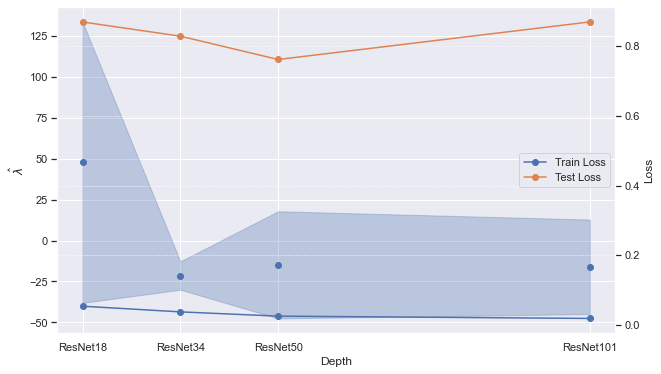

In [16]:
sns.set()

blue = sns.color_palette()[0]

resnet_depths = [18, 34, 50, 101]#, 152]

# Names for the different ResNet architectures
arch_names = ["ResNet18", "ResNet34", "ResNet50", "ResNet101"]# , "ResNet152"]

# Calculate means and standard deviations
means = [np.mean(_rlcts) for _rlcts in rlcts]
stds = [np.std(_rlcts) for _rlcts in rlcts]

# Calculate error bounds
lower_bounds = [mean - std for mean, std in zip(means, stds)]
upper_bounds = [mean + std for mean, std in zip(means, stds)]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the scatter points for the means
plt.scatter(resnet_depths, means, color=blue, label=r"Mean $\hat\lambda$", zorder=2)

# Plot the transparent area chart for the error bars
plt.fill_between(
    resnet_depths,
    lower_bounds,
    upper_bounds,
    color=blue,
    alpha=0.3,
    label=r"Std $\hat\lambda$",
)
plt.xlabel("Depth")
plt.ylabel(r"$\hat\lambda$")

# plot train/test loss using the following values
if train_losses == [] or test_losses == []:
    train_losses = [0.05407725289768102, 0.037803933233478845, 0.025594835435705527, 0.01902599687859112]#, 0.027865518259872893]
    test_losses = [0.8687256649136543, 0.8280440777540207, 0.7612130239605903, 0.8688971266150475]#, 0.906803734600544]
# plot
ax2 = plt.twinx()
ax2.plot(resnet_depths, train_losses, marker='o', label='Train Loss')
ax2.plot(resnet_depths, test_losses, marker='o', label='Test Loss')
ax2.set_ylabel('Loss')

plt.xticks(resnet_depths, arch_names)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Resnet18: Train Loss: 0.05407725289768102, Test Loss: 0.8687256649136543
# Resnet34: Train Loss: 0.037803933233478845, Test Loss: 0.8280440777540207
# Resnet50: Train Loss: 0.025594835435705527, Test Loss: 0.7612130239605903
# Resnet101: Train Loss: 0.01902599687859112, Test Loss: 0.8688971266150475
# Resnet152: Train Loss: 0.027865518259872893, Test Loss: 0.906803734600544

In [ ]:
means

[-43.93163280572629,
 21.554973077253564,
 43.51555223743376,
 -50.29613626590728,
 10.243158671058652]